In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [25]:
#Set some pandas parameters for outputs
pd.set_option('display.max_columns', 5)
pd.set_option('display.width', 1000)

In [26]:
### Define function for US map plotting ###
def plotByState(dataset, valueColName, stateColName = "State", countyColName = "FIPS Code", saveFilePath = "data/education/educationLevelsState.html"):
    #Extract only state data
    dataset = dataset[[countyColName, stateColName, valueColName]]
    datasetStates = dataset[dataset[countyColName]%1000 == 0]

    valueRange = (min(datasetStates[valueColName]), max(datasetStates[valueColName]))

    fig = px.choropleth(datasetStates, locations=datasetStates[stateColName], locationmode="USA-states",
    color=valueColName,color_continuous_scale="Viridis",
    range_color=valueRange,scope="usa",labels={valueColName:"Value"},
    hover_name=stateColName)
    
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig.write_html(saveFilePath, auto_open=True)

def plotByCounty(dataset, valueColName, countyColName = "FIPS Code"):
    #Extract only state data
    dataset = dataset[dataset[countyColName]%1000 != 0]

    fig = px.choropleth(dataset, geojson=counties, locations=countyColName, 
    color=valueColName,color_continuous_scale="Viridis", range_color=(0, 50),scope="usa",
    labels={valueColName:"Value"},hover_name=countyColName)
    
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig.write_html('data/education/educationLevelsCounty.html', auto_open=True)

In [27]:
#Load in cleaned dataset
educationDataset = pd.read_csv("data/cleaned/educationDataset.csv")

In [28]:
#Education Data
plotByState(educationDataset, "Percent of adults with a bachelor's degree or higher, 2014-18", saveFilePath = 'data/education/educationLevelsState.html')

In [29]:
#Economic Data
plotByState(educationDataset, "Unemployment_rate_2019", saveFilePath = 'data/education/unemployment.html')
plotByState(educationDataset, "Median_Household_Income_2019", saveFilePath = 'data/education/income.html')

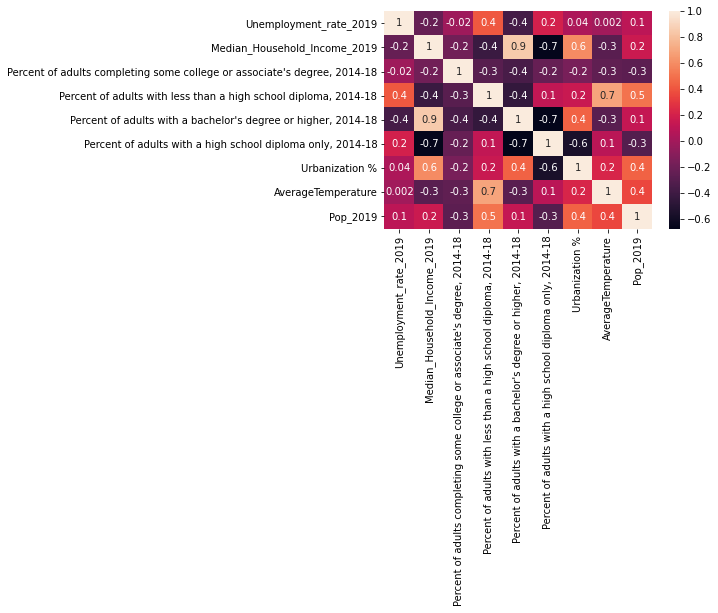

In [42]:
#Examine correlations
stateEducationDataset = pd.read_csv("data/cleaned/educationStateDataset.csv")

colNames = ["FIPS Code",
            "State",
            'Area Name',
            "Unemployment_rate_2019",
            "Median_Household_Income_2019",
            "Percent of adults completing some college or associate's degree, 2014-18",
            "Percent of adults with less than a high school diploma, 2014-18",
            "Percent of adults with a bachelor's degree or higher, 2014-18",
            "Percent of adults with a high school diploma only, 2014-18",
            "Urbanization %",
            "AverageTemperature",
            "Pop_2019"]

predictorDataset = stateEducationDataset[colNames]
predictorDataset.set_index("FIPS Code", inplace=True)
ax = sns.heatmap(predictorDataset.corr(), annot = True, fmt = '.1g')
plt.show()

In [43]:
### Load in state abbreviations to create single output dataframe ###
stateAbbreviations = pd.read_csv("data/US_state_abb.csv")
statePopulations = pd.read_csv("data/us_pop.csv")
#print(statePopulations)

### Load in covid data ###
usDailyCleaned = pd.read_csv("data/cleaned/daily_df.csv")

cols = ["date","deathIncrease","state_abb"]
usDailyCleaned = usDailyCleaned[cols]
usDailyCleaned = usDailyCleaned.fillna(0)

states = usDailyCleaned.groupby("state_abb")

outputCount = pd.DataFrame()
outputCount["Total"] = states["deathIncrease"].agg(np.sum)
outputCount = outputCount.reset_index()
outputCount = outputCount.rename(columns={"state_abb":"ABBREVIATION","US State":"state"})
outputCount = outputCount.merge(stateAbbreviations, how="left", on="ABBREVIATION")
outputCount = outputCount.drop(columns=["ABBREVIATION"])
outputCount = outputCount.rename(columns={"US State":"state"})
outputCount = outputCount.merge(statePopulations,how='left',on="state").dropna()
outputCount["Output"] = (outputCount["Total"]/outputCount["Pop_2019"])*100
outputCount = outputCount.drop(columns=["Pop_2019","Total"])

#print(outputCount)

### Load in misinformation data ###
stateMisinformation = pd.read_csv("data/cleaned/trend_all_time_state.csv")

cols = ["state","covid_conspiracy","covid_hoax","plandemic"]
colsToAvg = ["covid_conspiracy","covid_hoax","plandemic"]
stateMisinformation = stateMisinformation[cols]

stateMisinformation["Misinformation Mean"] = round(stateMisinformation[cols].mean(axis=1),2)

#print(stateMisinformation)

### Load in mobility data ###
stateMobility = pd.read_csv("data/cleaned/US_mobility_state_cleaned.csv")

cols = ["state","non_residential_percent_change_from_baseline"]
stateMobility = stateMobility[cols]

statesMobilityGroups = stateMobility.groupby("state")

mobilityStateAvg = pd.DataFrame()
mobilityStateAvg["Mobility"] = round(statesMobilityGroups["non_residential_percent_change_from_baseline"].agg(np.mean),2)

#print(mobilityStateAvg)

#Define output array

dependentVarsDf = pd.DataFrame()
dependentVarsDf["state"] = stateMisinformation["state"]
dependentVarsDf["Misinformation Index"] = stateMisinformation["Misinformation Mean"]
dependentVarsDf = dependentVarsDf.merge(outputCount,how='left',on='state')
dependentVarsDf = dependentVarsDf.merge(mobilityStateAvg,how='left',on='state')
dependentVarsDf = dependentVarsDf.rename(columns={"state":"State"})

#print(dependentVarsDf)

In [44]:
#Merge independent and dependent variables to create a single dataframe to run out regression
predictorDataset = predictorDataset.drop(columns=["State"])
predictorDataset = predictorDataset.rename(columns={"Area Name":"State"})
predictorDataset["Median_Household_Income_2019"] = predictorDataset["Median_Household_Income_2019"]/100 
df = predictorDataset.merge(dependentVarsDf,on="State",how='left')
print(df)

             State  Unemployment_rate_2019  ...    Output  Mobility
0          Alabama                     3.0  ...  0.190611     -4.96
1           Alaska                     6.1  ...  0.039369      2.56
2          Arizona                     4.7  ...  0.206946    -20.50
3         Arkansas                     3.5  ...  0.176055      3.26
4       California                     4.0  ...  0.120234    -25.38
5         Colorado                     2.8  ...  0.101376    -11.36
6      Connecticut                     3.7  ...  0.209689     -7.37
7         Delaware                     3.8  ...  0.135146    -11.15
8          Florida                     3.1  ...  0.138860    -25.21
9          Georgia                     3.4  ...  0.153267    -12.35
10          Hawaii                     2.7  ...  0.030158    -37.42
11           Idaho                     2.9  ...  0.101060     11.38
12        Illinois                     4.0  ...  0.175381    -11.36
13         Indiana                     3.3  ... 

In [46]:
xcols = ["Unemployment_rate_2019",
        "Median_Household_Income_2019",
        "Percent of adults completing some college or associate's degree, 2014-18",
        "AverageTemperature",
        "Urbanization %"]
X = df[xcols]

In [48]:
#Regression for misinformation
ycols = ["Misinformation Index"]
y = df[ycols]

X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     Misinformation Index   R-squared:                       0.542
Model:                              OLS   Adj. R-squared:                  0.490
Method:                   Least Squares   F-statistic:                     10.40
Date:                  Fri, 19 Feb 2021   Prob (F-statistic):           1.25e-06
Time:                          19:40:17   Log-Likelihood:                -175.74
No. Observations:                    50   AIC:                             363.5
Df Residuals:                        44   BIC:                             374.9
Df Model:                             5                                         
Covariance Type:              nonrobust                                         
============================================================================================================================================
                                                                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------------
const                                                                       42.5804     20.589      2.068      0.045       1.087      84.074
Unemployment_rate_2019                                                      -1.1010      1.732     -0.636      0.528      -4.591       2.389
Median_Household_Income_2019                                                 0.0242      0.020      1.222      0.228      -0.016       0.064
Percent of adults completing some college or associate's degree, 2014-18     0.9307      0.383      2.427      0.019       0.158       1.703
AverageTemperature                                                          -1.2598      0.346     -3.645      0.001      -1.956      -0.563
Urbanization %                                                              -0.1584      0.133     -1.187      0.242      -0.427       0.111
==============================================================================
Omnibus:                        3.617   Durbin-Watson:                   2.276
Prob(Omnibus):                  0.164   Jarque-Bera (JB):                2.561
Skew:                          -0.492   Prob(JB):                        0.278
Kurtosis:                       3.511   Cond. No.                     1.12e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.12e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [49]:
#Regression for mobility
ycols = ["Mobility"]
y = df[ycols]

X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Mobility   R-squared:                       0.658
Model:                            OLS   Adj. R-squared:                  0.620
Method:                 Least Squares   F-statistic:                     16.97
Date:                Fri, 19 Feb 2021   Prob (F-statistic):           2.53e-09
Time:                        19:40:18   Log-Likelihood:                -166.31
No. Observations:                  50   AIC:                             344.6
Df Residuals:                      44   BIC:                             356.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
============================================================================================================================================
                                                                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------------
const                                                                       59.3804     17.050      3.483      0.001      25.018      93.743
Unemployment_rate_2019                                                      -3.1781      1.434     -2.216      0.032      -6.069      -0.288
Median_Household_Income_2019                                                -0.0472      0.016     -2.878      0.006      -0.080      -0.014
Percent of adults completing some college or associate's degree, 2014-18     0.2128      0.318      0.670      0.506      -0.427       0.853
AverageTemperature                                                          -1.4455      0.286     -5.051      0.000      -2.022      -0.869
Urbanization %                                                              -0.1684      0.111     -1.523      0.135      -0.391       0.054
==============================================================================
Omnibus:                        3.467   Durbin-Watson:                   2.200
Prob(Omnibus):                  0.177   Jarque-Bera (JB):                2.458
Skew:                          -0.497   Prob(JB):                        0.293
Kurtosis:                       3.437   Cond. No.                     1.12e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.12e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [50]:
#Regression for covid
ycols = ["Output"]
y = df[ycols]

X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Output   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.268
Method:                 Least Squares   F-statistic:                     4.589
Date:                Fri, 19 Feb 2021   Prob (F-statistic):            0.00187
Time:                        19:40:20   Log-Likelihood:                 84.543
No. Observations:                  50   AIC:                            -157.1
Df Residuals:                      44   BIC:                            -145.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
============================================================================================================================================
                                                                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------------
const                                                                        0.4295      0.113      3.803      0.000       0.202       0.657
Unemployment_rate_2019                                                   -8.415e-05      0.010     -0.009      0.993      -0.019       0.019
Median_Household_Income_2019                                                -0.0003      0.000     -3.103      0.003      -0.001      -0.000
Percent of adults completing some college or associate's degree, 2014-18    -0.0069      0.002     -3.279      0.002      -0.011      -0.003
AverageTemperature                                                          -0.0022      0.002     -1.163      0.251      -0.006       0.002
Urbanization %                                                               0.0022      0.001      2.992      0.005       0.001       0.004
==============================================================================
Omnibus:                        5.298   Durbin-Watson:                   1.882
Prob(Omnibus):                  0.071   Jarque-Bera (JB):                4.661
Skew:                           0.745   Prob(JB):                       0.0972
Kurtosis:                       3.122   Cond. No.                     1.12e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.12e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""